In [6]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import torch.optim as optim
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import json
import torchvision
from torchvision import transforms
from torchvision.utils import save_image, make_grid
from torch.utils.data import Subset, random_split
from glob import glob
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import Image
import pandas as pd
import shutil
from pycocotools import mask as coco_mask
import os
from glob import glob
import matplotlib.pyplot as plt

In [ ]:
# import os

# from google.colab import drive
# drive.mount('/content/drive')

In [1]:
!git clone https://github.com/jasonfghx/retina_image.git

Cloning into 'retina_image'...
remote: Enumerating objects: 1687, done.
remote: Counting objects: 100% (52/52), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 1687 (delta 15), reused 0 (delta 0), pack-reused 1635 (from 2)
Receiving objects: 100% (1687/1687), 331.01 MiB | 16.36 MiB/s, done.
Resolving deltas: 100% (133/133), done.
Updating files: 100% (1404/1404), done.


In [2]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 977.1/977.1 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 63.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 49.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 77.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [ ]:
import cv2
import os
import numpy as np
os.makedirs('/content/retina_image/train')
os.makedirs('/content/retina_image/train/images')
os.makedirs('/content/retina_image/train/labels')

In [7]:
add=glob(r"/content/retina_image/Neo_Ridge/*")
for i in add[:]:
    image = cv2.imread(i)
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)

    clahe = cv2.createCLAHE(clipLimit=10.0, tileGridSize=(8,8))
    cl = clahe.apply(l)
    enhanced_lab = cv2.merge([cl,a,b])
    image = cv2.cvtColor(enhanced_lab, cv2.COLOR_LAB2BGR)
# 转换为灰度图像
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# 应用高斯模糊以减少噪声
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    blurred=cv2.medianBlur(blurred,3)
# 使用自适应阈值分割图像
    thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 15, 10)

# 使用形态学操作以细化结果
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    morph = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=1)
# 使用自适应阈值分割图像
    rho = 1  # distance resolution in pixels of the Hough grid
    theta = np.pi / 180  # angular resolution in radians of the Hough grid
    threshold = 20  # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 110  # minimum number of pixels making up a line
    max_line_gap = 20  # maximum gap in pixels between connectable line segments

    lines = cv2.HoughLinesP(morph, rho, theta, threshold, np.array([]),
                    min_line_length, max_line_gap)
    point_p_l=[]
    for line in lines:
      for x1,y1,x2,y2 in line:
          if y1<1750 and y1>500 and x1<1750 and x1>500 and x2<1700:
            if image[x1,y1][0]<125 and image[x2,y2][0]<125 and image[x2,y2][1]<140 and image[x1,y1][1]<140 and image[x1,y1][2]<130:
                point_p_l.append((x1,y1))
                point_p_l.append((x2,y2))
    #             cv2.line(image,(x1,y1),(x2,y2),(255,0,0),5)
    # plt.imshow(image)
    # plt.show()
    if len(point_p_l)!=0:
        hull = cv2.convexHull(np.array(point_p_l))
        cv2.fillPoly(image, [np.array((hull))], (0, 0,0))
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# # 定義紅色範圍（根據需求調整）
    lower_red1 = np.array([0, 70, 50])  # 第一部分紅色範圍（低色調）
    upper_red1 = np.array([10, 255, 255])

    lower_red2 = np.array([170, 70, 50])  # 第二部分紅色範圍（高色調）
    upper_red2 = np.array([180, 255, 255])

# 創建紅色遮罩
    mask1 = cv2.inRange(hsv, lower_red1, upper_red1)
    mask2 = cv2.inRange(hsv, lower_red2, upper_red2)
    red_mask = cv2.bitwise_or(mask1, mask2)

# 用黑色替換紅色部分
    image[red_mask > 0] = [0, 0, 0]
    name=i.split("/")[-1]
    cv2.imwrite('/content/retina_image/train/images/'+name,image)

KeyboardInterrupt: 

In [18]:
def mask_to_yolo_polygon(mask_image_path, path):
    label_file = open("/content/retina_image/train/labels/" + str(path.replace('.png','')) + '.txt', 'a')
    mask = cv2.imread(mask_image_path, cv2.IMREAD_GRAYSCALE)
    h, w = mask.shape[0], mask.shape[1]
    _, binary = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) #, 0.5, positive_orientation='low'

    for contour in contours:
        if len(contour) == 4 :continue
        # print(len(contour))
        label_file.write('0')
        label_file.write(' ')
        for cont in contour:
            label_file.write(str(cont[0][0] / w))
            label_file.write(' ')
            label_file.write(str(cont[0][1] / h))
            label_file.write(' ')
        label_file.write('\n')
    label_file.close()

for path in os.listdir("/content/retina_image/s1/masks"):
    # print(path)
    mask_image_path = "/content/retina_image/s1/masks/" + str(path)
    mask_to_yolo_polygon(mask_image_path, path)

In [19]:
import yaml

d ={'train':"/content/retina_image/train",'val': '/content/retina_image/train',
    'test':'/content/retina_image/train','names':['d'],'nc':1}


with open('/content/retina_image/data.yaml', 'w') as f:
    yaml.dump(d, f)

In [2]:
from ultralytics import YOLO
model = YOLO("yolov8n-seg.pt")
# model =YOLO('/content/runs/segment/train2/weights/last.pt')

# Train the model
train_results = model.train(
    data="/content/retina_image/data.yaml",  # path to dataset YAML
    epochs=60,  # number of training epochs
    imgsz=640,batch=8,lr0=0.001, lrf=0.0005  # training image size
     # device to run on, i.e. device=0 or device=0,1,2,3 or device=cpu
)

Ultralytics 8.3.100 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=segment, mode=train, model=/content/runs/segment/train2/weights/last.pt, data=/content/retina_image/data.yaml, epochs=60, time=None, patience=100, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, sho

train: Scanning /content/retina_image/train/labels.cache... 0 images, 60 backgrounds, 0 corrupt: 100%|██████████| 60/60 [00:00<?, ?it/s]

WARNING ⚠️ No labels found in /content/retina_image/train/labels.cache, training may not work correctly. See https://docs.ultralytics.com/datasets for dataset formatting guidance.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/retina_image/train/labels.cache... 0 images, 60 backgrounds, 0 corrupt: 100%|██████████| 60/60 [00:00<?, ?it/s]


WARNING ⚠️ No labels found in /content/retina_image/train/labels.cache, training may not work correctly. See https://docs.ultralytics.com/datasets for dataset formatting guidance.
Plotting labels to runs/segment/train3/labels.jpg... 
zero-size array to reduction operation maximum which has no identity
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 66 weight(decay=0.0), 77 weight(decay=0.0005), 76 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/segment/train3
Starting training for 60 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/60      1.71G          0          0      39.93          0          0        640: 100%|██████████| 8/8 [00:03<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.98it/s]

                   all         60          0          0          0          0          0          0          0          0          0
WARNING ⚠️ no labels found in segment set, can not compute metrics without labels



/usr/local/lib/python3.11/dist-packages/ultralytics/utils/metrics.py:654: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


KeyboardInterrupt: 

In [ ]:
results = model(source="/content/retina_image/train/images/16.png", imgsz=640)
results  # 顯示結果
# results.save()


image 1/1 /content/retina_image/train/images/16.png: 640x640 (no detections), 25.1ms
Speed: 12.9ms preprocess, 25.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'd'}
 obb: None
 orig_img: array([[[15, 15, 15],
         [15, 15, 15],
         [15, 15, 15],
         ...,
         [15, 15, 15],
         [15, 15, 15],
         [15, 15, 15]],
 
        [[15, 15, 15],
         [15, 15, 15],
         [15, 15, 15],
         ...,
         [15, 15, 15],
         [15, 15, 15],
         [15, 15, 15]],
 
        [[15, 15, 15],
         [15, 15, 15],
         [15, 15, 15],
         ...,
         [15, 15, 15],
         [15, 15, 15],
         [15, 15, 15]],
 
        ...,
 
        [[15, 15, 15],
         [15, 15, 15],
         [15, 15, 15],
         ...,
         [15, 15, 15],
         [15, 15, 15],
         [15, 15, 15]],
 
        [[15, 15, 15],
         [15, 15, 15],
         [15, 15, 15],
         ...,
         [15, 15, 15],
         [15, 15, 15],
         [15, 15, 15]],
 
        [[15, 15, 15],
         

In [8]:
from ultralytics import YOLO
model = YOLO("/content/last.pt")


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [9]:
results = model(source="/content/retina_image/train/images/11.png", imgsz=640)


image 1/1 /content/retina_image/train/images/11.png: 640x640 1 d, 1559.4ms
Speed: 22.2ms preprocess, 1559.4ms inference, 62.1ms postprocess per image at shape (1, 3, 640, 640)


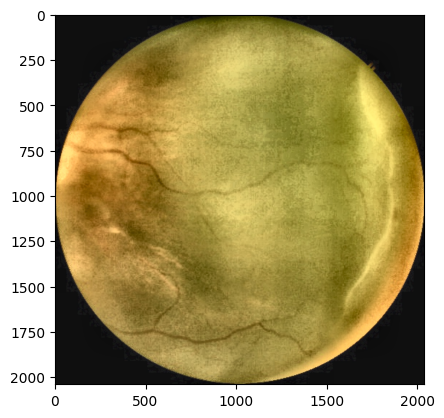

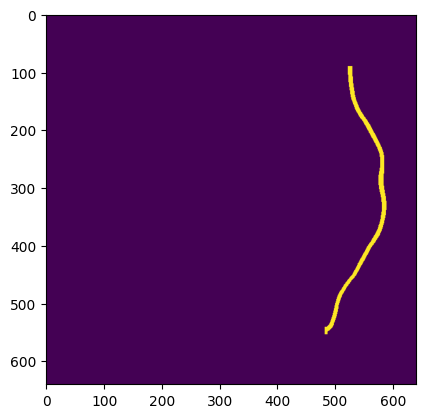

In [10]:
# plt

plt.imshow(results[0].orig_img[:,:,::-1])
plt.show()
plt.imshow(results[0].masks.data.numpy()[0])
plt.show()